In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# LOADS PRE-EXISTING NET

Weights can be found at https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h put into data folder

Processing...
Done!


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

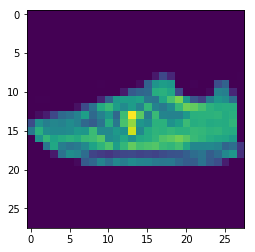

In [27]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.FashionMNIST(root="./fmnist-data", train=True, transform=trans, download=True)
test_set2 = dset.FashionMNIST(root="./fmnist-data", train=False, transform=trans, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader2 = torch.utils.data.DataLoader(
                dataset=test_set2,
                batch_size=batch_size,
                shuffle=False)

index = 17
for counter, (img, label) in enumerate(test_loader2):
    if counter == index:
        break
    source_img = img[0, 0]
    source_label = label[0]

source_img = source_img.reshape(1, 1, 28, 28)
source_label = source_label.reshape(1)
fig, ax = plt.subplots()
ax.imshow(source_img[0, 0])

use_cuda = False
epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = "data/lenet_mnist_model.pth"

criterion = nn.CrossEntropyLoss()

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
# Initialize the network
model = Net()

# Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# TRAINS NEW NET DO NOT RUN

In [33]:


# print '==>>> total trainning batch number: {}'.format(len(train_loader))
# print '==>>> total testing batch number: {}'.format(len(test_loader))

## network
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        #self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv2_bn = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

## training
model = LeNet()

if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
print ("Starting to train this shit lmao")

for epoch in range(35):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.data.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print("Epoch", epoch)
            print("==>>> epoch: {}, batch index: {}, train loss: {:.6f}".format(epoch, batch_idx+1, ave_loss))
    # testing
#     correct_cnt, ave_loss = 0, 0
#     total_cnt = 0
#     for batch_idx, (x, target) in enumerate(test_loader):
#         if use_cuda:
#             x, target = x.cuda(), target.cuda()
#         x, target = Variable(x, volatile=True), Variable(target, volatile=True)
#         out = model(x)
#         loss = criterion(out, target)
#         _, pred_label = torch.max(out.data, 1)
#         total_cnt += x.data.size()[0]
#         correct_cnt += (pred_label == target.data).sum()
#         # smooth average
#         ave_loss = ave_loss * 0.9 + loss.data[0] * 0.1
        
#         if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
#             print("Epoch", epoch)
# #             print '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
# #                 epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt)
  

Starting to train this shit lmao
Epoch 0
==>>> epoch: 0, batch index: 100, train loss: 1.031172
Epoch 0
==>>> epoch: 0, batch index: 200, train loss: 0.687322
Epoch 0
==>>> epoch: 0, batch index: 300, train loss: 0.637741
Epoch 0
==>>> epoch: 0, batch index: 400, train loss: 0.550147
Epoch 0
==>>> epoch: 0, batch index: 500, train loss: 0.518729
Epoch 0
==>>> epoch: 0, batch index: 600, train loss: 0.488831
Epoch 1
==>>> epoch: 1, batch index: 100, train loss: 0.450523
Epoch 1
==>>> epoch: 1, batch index: 200, train loss: 0.431190
Epoch 1
==>>> epoch: 1, batch index: 300, train loss: 0.443611
Epoch 1
==>>> epoch: 1, batch index: 400, train loss: 0.430838
Epoch 1
==>>> epoch: 1, batch index: 500, train loss: 0.367662
Epoch 1
==>>> epoch: 1, batch index: 600, train loss: 0.391560
Epoch 2
==>>> epoch: 2, batch index: 100, train loss: 0.390143
Epoch 2
==>>> epoch: 2, batch index: 200, train loss: 0.355257
Epoch 2
==>>> epoch: 2, batch index: 300, train loss: 0.361769
Epoch 2
==>>> epoch: 2

Epoch 21
==>>> epoch: 21, batch index: 300, train loss: 0.146072
Epoch 21
==>>> epoch: 21, batch index: 400, train loss: 0.154589
Epoch 21
==>>> epoch: 21, batch index: 500, train loss: 0.121304
Epoch 21
==>>> epoch: 21, batch index: 600, train loss: 0.154256
Epoch 22
==>>> epoch: 22, batch index: 100, train loss: 0.117123
Epoch 22
==>>> epoch: 22, batch index: 200, train loss: 0.115156
Epoch 22
==>>> epoch: 22, batch index: 300, train loss: 0.128641
Epoch 22
==>>> epoch: 22, batch index: 400, train loss: 0.140133
Epoch 22
==>>> epoch: 22, batch index: 500, train loss: 0.145282
Epoch 22
==>>> epoch: 22, batch index: 600, train loss: 0.124155
Epoch 23
==>>> epoch: 23, batch index: 100, train loss: 0.132299
Epoch 23
==>>> epoch: 23, batch index: 200, train loss: 0.105873
Epoch 23
==>>> epoch: 23, batch index: 300, train loss: 0.117929
Epoch 23
==>>> epoch: 23, batch index: 400, train loss: 0.106750
Epoch 23
==>>> epoch: 23, batch index: 500, train loss: 0.133237
Epoch 23
==>>> epoch: 23,

In [36]:
correct_cnt, ave_loss = 0, 0
total_cnt = 0
epoch = 0
for batch_idx, (x, target) in enumerate(test_loader2):
    if use_cuda:
        x, target = x.cuda(), target.cuda()
    x, target = Variable(x, volatile=True), Variable(target, volatile=True)
    out = model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    # smooth average
    ave_loss = ave_loss * 0.9 + loss.data.item() * 0.1

    if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
        print("Epoch", epoch)
        print(correct_cnt, total_cnt)
#             print '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
#                 epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


Epoch 0
tensor(9089) 10000


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor(1., grad_fn=<MaxBackward0>) tensor(9)
tensor(1.0000, grad_fn=<MaxBackward0>) tensor(3)
tensor(1., grad_fn=<MaxBackward0>) tensor(1)
tensor(0.9998, grad_fn=<MaxBackward0>) tensor(3)
tensor(1.0000, grad_fn=<MaxBackward0>) tensor(0)
tensor(0.9990, grad_fn=<MaxBackward0>) tensor(2)
tensor(0.9776, grad_fn=<MaxBackward0>) tensor(2)
tensor(1.0000, grad_fn=<MaxBackward0>) tensor(8)
torch.Size([1, 1, 28, 28])
torch.Size([1])


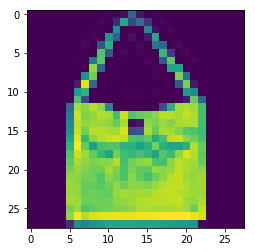

In [84]:
index = 8
for counter, (img, label) in enumerate(test_loader2):
    if counter == index:
        break
    predict = model(img)
    predict = torch.nn.functional.softmax(predict)
    predict_vect, predict_label = torch.max(predict[0], 0)
    print(predict_vect, predict_label)
    loss = criterion(predict, label)
    source_img = img[0, 0]
    source_label = label[0]

source_img = source_img.reshape(1, 1, 28, 28)
source_label = source_label.reshape(1)
print(source_img.shape)
print(source_label.shape)
fig, ax = plt.subplots()
ax.imshow(source_img[0, 0])

Initial Loss: tensor([[ 10.6142, -22.2906,  -1.1345,  -4.8833,   5.8750,  -7.1243,  -2.4411,
          -2.5783,  25.7800,  -3.8159]], grad_fn=<ThAddmmBackward>)
Init Adv: tensor([[  6.6270, -15.6452,  -1.3620,  -2.6086,   9.0533,  -7.3460,   3.6207,
          -4.2898,  11.1521,  -0.9363]], grad_fn=<ThAddmmBackward>)
torch.Size([1, 1, 28, 28]) torch.Size([1])
Finding Adverserial Vector: 0.0%
0.12573528289794922
A_NL VAL: -0.692467451095581
TIME TAKEN: 0.007027864456176758

Finding Adverserial Vector: 10.0%
5.948226451873779
A_NL VAL: -6.39735221862793
TIME TAKEN: 0.003936052322387695

Finding Adverserial Vector: 20.0%
5.676581382751465
A_NL VAL: -7.912100315093994
TIME TAKEN: 0.00374603271484375

Finding Adverserial Vector: 30.0%
5.08554744720459
A_NL VAL: -11.609257698059082
TIME TAKEN: 0.0037927627563476562

Finding Adverserial Vector: 40.0%
4.034214973449707
A_NL VAL: -39.59215545654297
TIME TAKEN: 0.00368499755859375

Finding Adverserial Vector: 50.0%
3.0040979385375977
A_NL VAL: -4

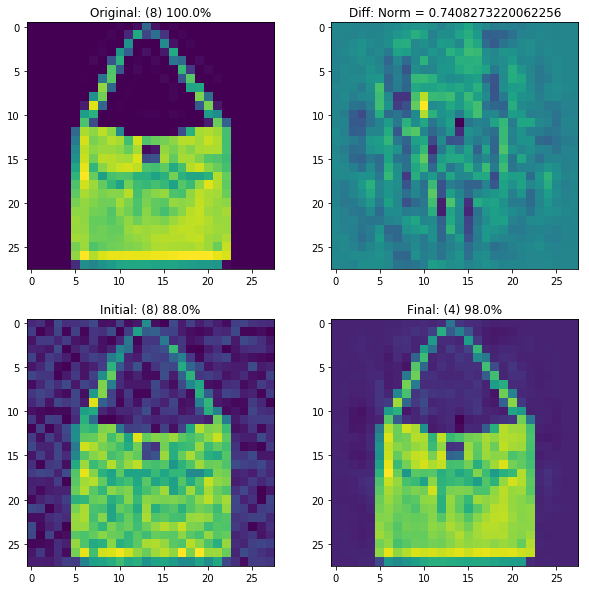

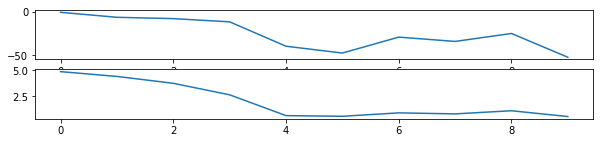

In [90]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x


class MyBCE(nn.Module):
    def __init__(self):
        super(MyBCE, self).__init__()
        
    def forward(self, p, y):
        return -1*(y * torch.log(p) + (1 - y) * torch.log(1 - p))
# df_loss = DiffLoss(F.BCELoss())



def trainAdversary(model, source_img, source_label):
    
    N = model # initialize sigmoid layer
    a = torch.autograd.Variable(source_img, requires_grad = True)
    y = torch.autograd.Variable(source_label, requires_grad = False)
    x = torch.autograd.Variable(torch.rand(1, 1, 28, 28)*0.3, requires_grad = True)
    x_init = x.clone()
    
    print("Initial Loss:", N(a))
    print("Init Adv:", N(a + x))
    print(a.shape, y.shape)
    loss_fn = criterion

    lr = 0.001
    num_epochs = 4000
    optimizer = optim.SGD([x], lr=lr)
    A_NL_training = []
    x_norm_training = []
    for epoch in range(num_epochs):
        t1 = time.time()
        N.zero_grad()
        optimizer.zero_grad()

        loss_adv = loss_fn(N(a + x), y)
        loss_source = loss_fn(N(a), y)

        loss_diff = torch.abs(loss_adv - loss_source) / torch.norm(x)
        grads = grad(loss_diff, x, create_graph=True)
        A_NL = -1*torch.norm(grads[0])

        grads = A_NL.backward()

        if epoch % (num_epochs/10) == 0:
            A_NL_training.append(A_NL.item())
            x_norm_training.append(torch.norm(x).item())
    #       lr_val = torch.norm(grads)
            print("Finding Adverserial Vector: " + str(100*(epoch // 50)*(50/num_epochs))+"%")
            print(loss_adv.item())
            print("A_NL VAL:", A_NL.item())
    #       print("NEW LR", np.log(1 / lr_val))
    #       print("GRAD VAL:", np.log(1 / lr_val)*lr)
            print("TIME TAKEN:", time.time() - t1)
            print()
    #     x = x - lr*grads
        optimizer.step()
        
    return x, a, x_init, A_NL_training, x_norm_training

def drawPlot(x, a, x_init, N, A_NL_training, x_norm_training):
    
    result_original = torch.nn.functional.softmax(N(a)[0], dim=0)
    predict_vect_original, predict_label_original = torch.max(result_original, 0)
    predict_vect_original = round(predict_vect_original.item(), 2)

    result = torch.nn.functional.softmax(N(x + a)[0], dim=0)
    predict_vect, predict_label = torch.max(result, 0)
    predict_vect = round(predict_vect.item(), 2)

    result_init = torch.nn.functional.softmax(N(x_init + a)[0], dim=0)
    predict_vect_init, predict_label_init = torch.max(result_init, 0)
    predict_vect_init = round(predict_vect_init.item(), 2)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0,0].imshow((a)[0, 0].data)
    ax[0,0].set_title("Original: (" + str(y.item())+") "+str(predict_vect_original*100)+"%")

    ax[0,1].imshow((x)[0, 0].data)
    ax[0,1].set_title("Diff: Norm = " + str(torch.norm(x).item()))

    ax[1,1].imshow((x + a)[0, 0].data)
    ax[1,1].set_title("Final: (" + str(predict_label.item())+") "+str(predict_vect*100)+"%")

    ax[1,0].imshow((x_init + a)[0, 0].data)
    ax[1,0].set_title("Initial: (" + str(predict_label_init.item())+") "+str(predict_vect_init*100)+"%")
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 2))
    
    ax[0].plot(A_NL_training)
    ax[1].plot(x_norm_training)
    
x, a, x_init, A_NL_training, x_norm_training = trainAdversary(model, source_img, source_label)
drawPlot(x, a, x_init, model, A_NL_training, x_norm_training)


In [77]:
x, a, x_init, A_NL_training, x_norm_training = trainAdversary(model, source_img, source_label)
drawPlot(x, a, x_init, model, A_NL_training, x_norm_training)